In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
def pi(X, theta):
    return jax.nn.softmax(X @ theta)

@jax.grad
def df(theta, X, r):
    return jax.nn.softmax(X @ theta) @ r

In [3]:
def f(X, r, theta):
    m = (X[2] - X[1]).dot(X[0] - X[2]) / (X[0] - X[1]).dot(X[0] - X[2]) * (pi(X, theta).dot(r) - r[2]) / (r[0] - pi(X, theta).dot(r))
    c = - np.log(m) / np.linalg.norm(X[2] - X[0]) ** 2
    return c

In [4]:
def color_map_with_gradients(X, r, trajectory=None, map_range=(-5, 5)):
    # Create a coarser grid for gradients
    theta_vals = np.linspace(map_range[0], map_range[1], 20)
    Theta1, Theta2 = np.meshgrid(theta_vals, theta_vals)
    Z = np.zeros_like(Theta1)
    U = np.zeros_like(Theta1)  # Gradient in theta1 direction
    V = np.zeros_like(Theta2)  # Gradient in theta2 direction

    # Compute expected rewards and gradients over the grid
    for i in range(Theta1.shape[0]):
        for j in range(Theta1.shape[1]):
            theta = np.array([Theta1[i, j], Theta2[i, j]])
            Z[i, j] = pi(X, theta) @ r
            grad = df(theta, X, r, )
            U[i, j] = grad[0]
            V[i, j] = grad[1]

    # Normalize gradients for plotting
    M = np.hypot(U, V)
    U_norm = U / M
    V_norm = V / M

    # Plot filled contours
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(Theta1, Theta2, Z, levels=100, cmap='viridis')
    plt.colorbar(contour)
    plt.contour(Theta1, Theta2, Z, levels=100, colors='black', linewidths=0.5)

    # Plot gradient vectors
    plt.quiver(Theta1, Theta2, U_norm, V_norm, color='white')

    # Plot the trajectory if provided
    if trajectory is not None:
        trajectory = np.array(trajectory)
        plt.plot(trajectory[:, 0], trajectory[:, 1], 'r.-', markersize=1)

        # Add an arrow at the end of the trajectory
        start_point = trajectory[-2]
        end_point = trajectory[-1]
        dx = end_point[0] - start_point[0]
        dy = end_point[1] - start_point[1]
        plt.arrow(
            start_point[0], start_point[1],
            dx, dy,
            head_width=0.2,
            head_length=0.3,
            fc='red',
            ec='red',
            linewidth=2
        )

    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.title('Expected Reward Landscape with Gradients')
    plt.show()

In [5]:
@jax.jit
def jincheng_linear_pg(theta, r, eta, X):

    grad = df(theta, X, r)
    theta = theta + eta * grad

    return theta

In [6]:
def run(update, T, theta_0, *args):
    trajectory = np.zeros((T, 2))
    theta = theta_0
    trajectory[0] = theta
    for i in range(1, T):
        theta = update(theta, *args)
        trajectory[i] = theta
    return trajectory

# Example 1

In [7]:
X = jnp.array([[0.0, -2.0], [-1.0, 0.0], [0.0, 1.0], [2.0, 0.0]])
r = jnp.array([9.0, 8.0, 7.0, 6.0])
theta_0 = jnp.array([3.0, 3.0])

In [8]:
T = 10000
eta = 0.2

trajectory = run(jincheng_linear_pg, T, theta_0, r, eta, X)

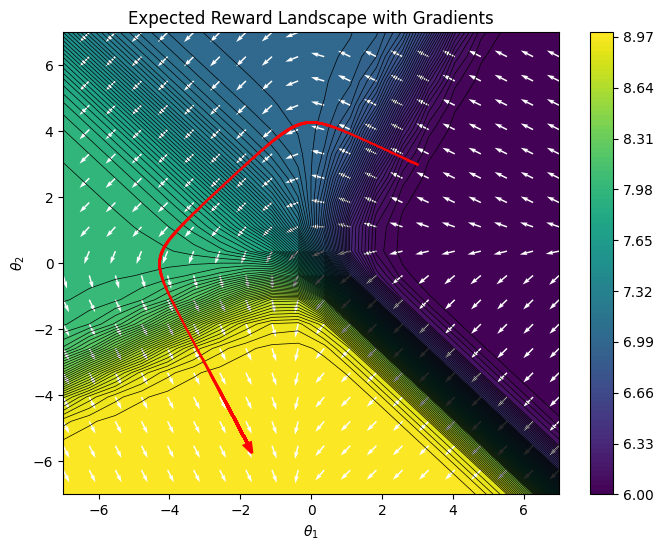

In [9]:
color_map_with_gradients(X, r, trajectory, (-7, 7))

# Example 2

In [10]:
X = jnp.array([[0.0, -2.0], [0.0, 1.0], [-1.0, 0.0], [2.0, 0.0]])
r = jnp.array([9.0, 8.0, 7.0, 6.0])
theta_0 = jnp.array([3.0, 3.0])

In [11]:
T = 1000
eta = 0.2

trajectory = run(jincheng_linear_pg, T, theta_0, r, eta, X)

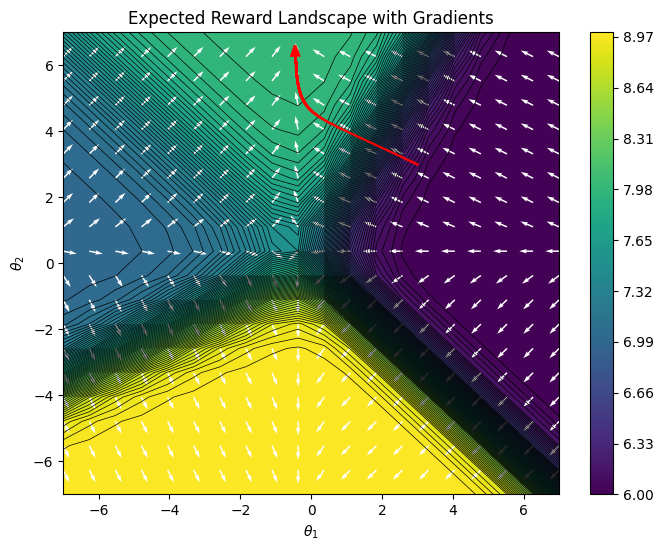

In [12]:
color_map_with_gradients(X, r, trajectory, (-7, 7))

# Example 3

In [13]:
X = jnp.array([[0.0, -1.0], [-0.3, 0.6], [1.0, 0.0]])
r = jnp.array([1.0, 0.5, 0.0])
theta_0 = jnp.array([2.0, 2.0])

In [14]:
T = 3_000
eta = 4 / (9 * max(r) * np.linalg.eigh(X.T @ X)[0][-1])

trajectory = run(jincheng_linear_pg, T, theta_0, r, eta, X)

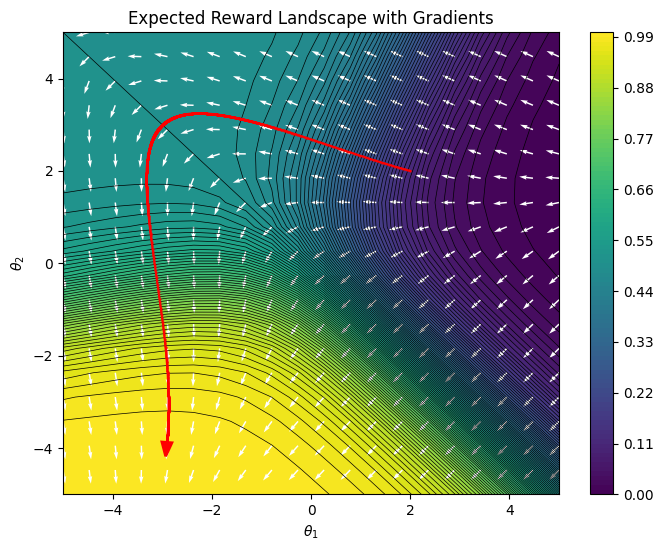

In [15]:
color_map_with_gradients(X, r, trajectory)

# Example 4

In [16]:
X = jnp.array([[0.0, -1.0], [0.6, 0.6], [1.0, 0.0]])
r = jnp.array([1.0, 0.5, 0.0])
theta_0 = jnp.array([2.0, 2.0])
print(f(X, r, theta_0))

1.6120307997300758


In [17]:
T = 200
eta = 4 / (9 * max(r) * np.linalg.eigh(X.T @ X)[0][-1])

trajectory = run(jincheng_linear_pg, T, theta_0, r, eta, X)

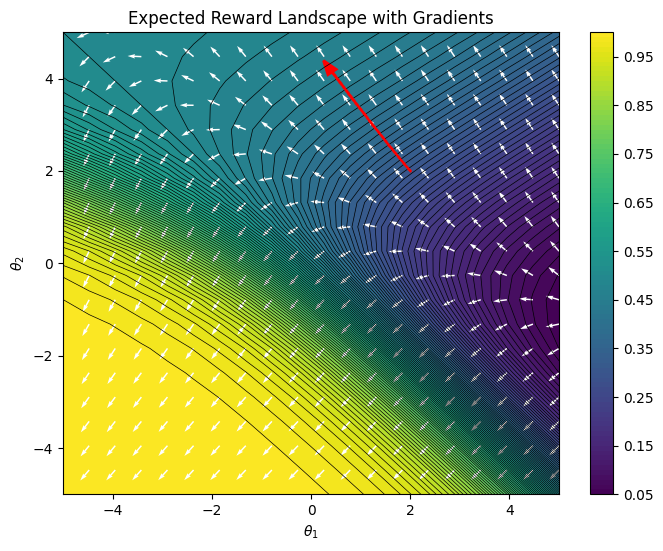

In [18]:
color_map_with_gradients(X, r, trajectory)

# Proposition 5

In [37]:
X = jnp.array([[3.0, 4.0], [5.0, 6.0], [1.0, 2.0]])
r = jnp.array([3.0, 2.0, 1.0])
theta_0 = jnp.array([1.0, 1.0])

In [44]:
T = 5000
eta = 4 / (9 * max(r) * np.linalg.eigh(X.T @ X)[0][-1])

trajectory = run(jincheng_linear_pg, T, theta_0, r, eta, X)

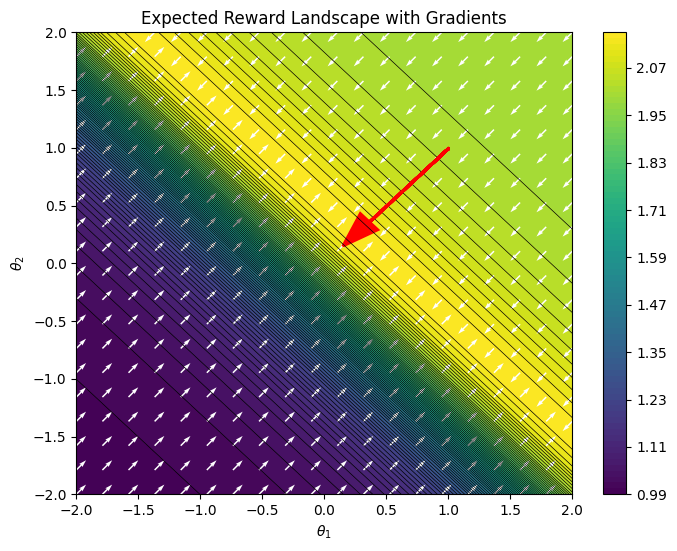

In [47]:
color_map_with_gradients(X, r, trajectory, (-2, 2))